In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Activation, Dropout, GlobalAveragePooling2D, Dense
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from imutils import paths
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import img_to_array
from keras.applications import imagenet_utils
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix
import os
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

#### Tiền xử lí dữ liệu

In [3]:
# Lấy các đường dẫn đến ảnh.
# image_path = list(paths.list_images('data/dogs-vs-cats/train/train'))
image_path = list(paths.list_images('/content/drive/MyDrive/5_AIADVANCE/GK_AI_Advance/dogs-vs-cats'))

# Đổi vị trí ngẫu nhiên các đường dẫn ảnh
random.shuffle(image_path)

# Chỉ lấy 5000 dòng đầu tiên (5000 ảnh)
# image_path = image_path[:5000]
# print(image_path)

In [4]:
labels = [p.split(os.path.sep)[-1] for p in image_path]
labels = [label.split('.')[-3] for label in labels]
print(labels)
# Chuyển tên các loài hoa thành số
le = LabelEncoder()
labels = le.fit_transform(labels)
print(labels)

['dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat'

In [5]:
# Load ảnh và resize về đúng kích thước mà VGG 16 cần là (224,224)
list_image = []
for (j, imagePath) in enumerate(image_path):
    # Load ảnh và resize về kích thước (224, 224)
    image = load_img(imagePath, target_size=(224, 224))

    # Chuyển ảnh thành mảng numpy
    image = img_to_array(image)

    # Mở rộng chiều của mảng numpy
    image = np.expand_dims(image, 0)

    # Tiền xử lý ảnh theo tiêu chuẩn của mô hình VGG16
    image = imagenet_utils.preprocess_input(image)

    # Thêm ảnh đã tiền xử lý vào danh sách
    list_image.append(image)

# Chuyển danh sách các ảnh thành mảng numpy một chiều
list_image = np.vstack(list_image)

In [6]:
print(list_image.shape)

(5000, 224, 224, 3)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(list_image, labels, test_size=0.2, random_state=42)

#### Xây dựng Model

In [8]:
def fire_module(x, squeeze, expand):
    squeezed = Conv2D(squeeze, (1, 1), activation='relu', padding='same')(x)
    expand1x1 = Conv2D(expand, (1, 1), activation='relu', padding='same')(squeezed)
    expand3x3 = Conv2D(expand, (3, 3), activation='relu', padding='same')(squeezed)
    output = concatenate([expand1x1, expand3x3], axis=-1)
    return output

input_img = Input(shape=(224, 224, 3))

x = Conv2D(64, (3, 3), strides=(2, 2), padding='valid', activation='relu')(input_img)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

x = fire_module(x, squeeze=16, expand=64)
x = fire_module(x, squeeze=16, expand=64)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

x = fire_module(x, squeeze=32, expand=128)
x = fire_module(x, squeeze=32, expand=128)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

x = fire_module(x, squeeze=48, expand=192)
x = fire_module(x, squeeze=48, expand=192)
x = fire_module(x, squeeze=64, expand=256)
x = fire_module(x, squeeze=64, expand=256)

x = Dropout(0.5)(x)

x = Conv2D(1000, (1, 1), activation='relu', padding='same')(x)
x = GlobalAveragePooling2D()(x)
output = Dense(2, activation='softmax')(x)
# output = Activation('softmax')(x)


In [9]:
model = Model(input_img, output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 55, 55, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 55, 55, 16)           1040      ['max_pooling2d[0][0]']   

#### Fit model

In [ ]:
# Tạo đối tượng optimizer
optimizer = tf.keras.optimizers.Adam()

save_best_only = True
checkpoint = ModelCheckpoint('models/model-SqueezeNet-{epoch:03d}.keras',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=save_best_only,
                             mode='auto')

# Xây dựng quy trình huấn luyện
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Huấn luyện mô hình với dữ liệu đã chuẩn bị
H = model.fit(X_train, y_train, epochs=10, batch_size=2, validation_split=0.2, callbacks=[checkpoint])

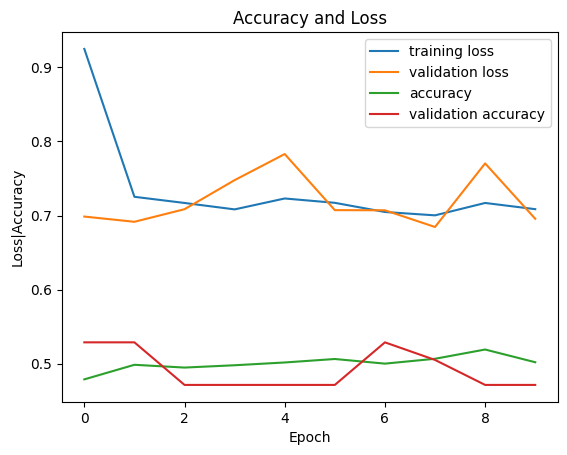

In [ ]:
# Vẽ đồ thị loss, accuracy của traning set và validation set
fig = plt.figure()
numOfEpoch = 10
plt.plot(np.arange(0, numOfEpoch), H.history['loss'], label='training loss')
plt.plot(np.arange(0, numOfEpoch), H.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, numOfEpoch), H.history['accuracy'], label='accuracy') # sử dụng từ khóa accuracy thay vì acc
plt.plot(np.arange(0, numOfEpoch), H.history['val_accuracy'], label='validation accuracy') # sử dụng từ khóa val_accuracy thay vì val_acc
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()

In [ ]:
# Đánh giá model với dữ liệu test set
score = model.evaluate(X_test, y_test, verbose=1)
print(score)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.5045 - loss: 0.6907
[0.6934720277786255, 0.48399999737739563]


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 55, 55,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 55, 55,    │      1,040 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 55, 55,    │      1,088 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 55, 55,    │      9,280 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 55, 55,    │          0 │ conv2d_2[0][0],   │
│ (Concatenate)       │ 128)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 55, 55,    │      2,064 │ concatenate[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 55, 55,    │      1,088 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 55, 55,    │      9,280 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 55, 55,    │          0 │ conv2d_5[0][0],   │
│ (Concatenate)       │ 128)              │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 27, 27,    │          0 │ concatenate_1[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 27, 27,    │      4,128 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 27, 27,    │      4,224 │ conv2d_7[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 27, 27,    │     36,992 │ conv2d_7[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 27, 27,    │          0 │ conv2d_8[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 27, 27,    │      8,224 │ concatenate_2[0]

 Total params: 3,706,490 (14.14 MB)

 Trainable params: 1,235,496 (4.71 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,470,994 (9.43 MB)

In [ ]:
# Đánh giá model
preds = model.predict(X_test) # DỰ ĐOÁN VÀ ĐÁNH GIÁ
preds = np.argmax(preds, axis=1)
print(classification_report(y_test, preds))

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       516
           1       0.48      1.00      0.65       484

    accuracy                           0.48      1000
   macro avg       0.24      0.50      0.33      1000
weighted avg       0.23      0.48      0.32      1000



c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


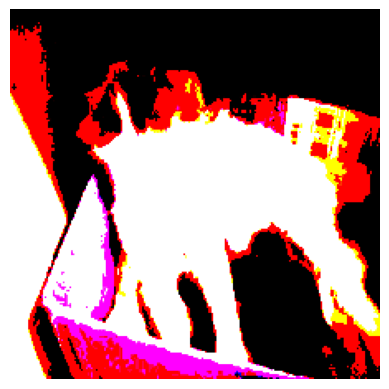

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Giá trị dự đoán:  1


In [ ]:
# 10. Dự đoán ảnh
plt.imshow(X_test[0])
plt.axis('off')
plt.show()

y_predict = model.predict(np.expand_dims(X_test[0], axis=0))
print('Giá trị dự đoán: ', np.argmax(y_predict))

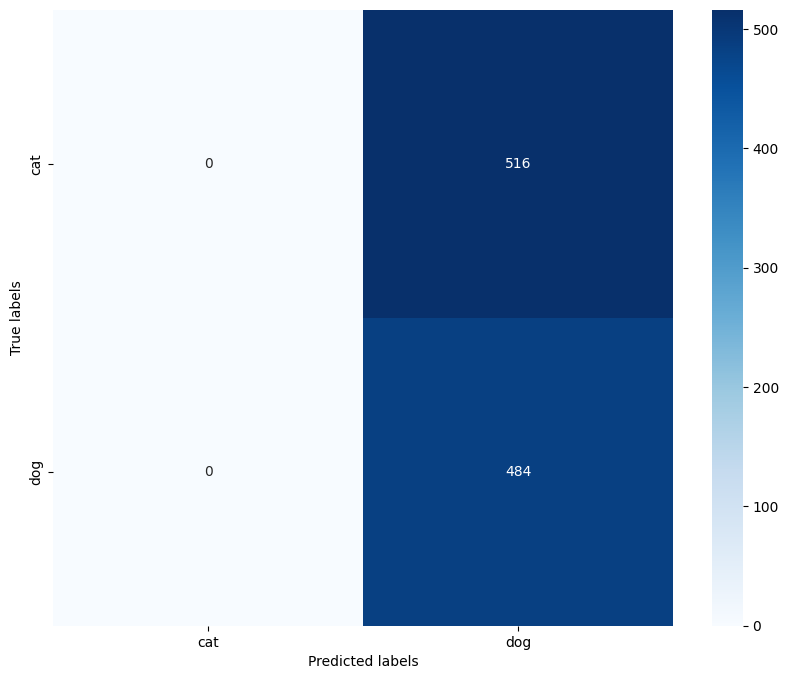

In [ ]:
# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test, preds)

# Chuyển nhãn số thành tên
label_names = le.inverse_transform(np.unique(y_test))
label_names = [label.split('/')[-1] for label in label_names]
# Sắp xếp lại ma trận nhầm lẫn
sorted_cm = cm[np.argsort(label_names)][:, np.argsort(label_names)]

# Tạo dataframe từ ma trận nhầm lẫn đã sắp xếp lại
df_cm = pd.DataFrame(sorted_cm, index=label_names, columns=label_names)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
